### Plot the magnetization of a halbach array, and add the magnetization of shimming sphere

In [320]:
def mSymFunc(m,factors=1, flipDipolexy=False, symmetryAngle=np.pi / 3):
   # phiSym = phi0 + (-symmetryAngle) * factors  # symmetryAngle to rotate the dipole position by
   deltaTheta = -symmetryAngle * factors  # symmetryAngle to rotate the dipole direction vector by
   mSym = m.copy()
   MRot = np.array([[np.cos(deltaTheta), -np.sin(deltaTheta)], [np.sin(deltaTheta), np.cos(deltaTheta)]])
   mSym = MRot @ mSym
   if flipDipolexy == True:
       mSym = -mSym
   print(m,mSym)
   return mSym

[ 0.92369335 -0.3831326 ] [ 0.92369335 -0.3831326 ]
[ 0.92369335 -0.3831326 ] [-0.13004411  0.99150821]
[ 0.92369335 -0.3831326 ] [-0.79364924 -0.60837561]


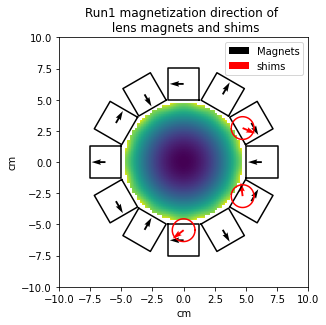

In [322]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.affinity import rotate
from HalbachLensClass import Layer

rp=(.05,)
width=.0254

thetaArr = np.linspace(0, 2 * np.pi, 12, endpoint=False)  # location of 12 magnets
thetaArr=thetaArr.reshape(-1,len(rp)).T
phiArr = np.pi + np.arange(0, 12) * 2 * np.pi / 3 #direction of magnetization
phiArr=phiArr.reshape(-1,len(rp)).T
quiverData=[]
for r,r_phi,r_theta in zip(rp,phiArr,thetaArr):
    for phi,theta in zip(r_phi,r_theta):
        x,y=(r+width/2)*np.cos(theta)*1e2,(r+width/2)*np.sin(theta)*1e2
        quiverData.append([x,y,np.cos(phi),np.sin(phi)])
quiverData=np.asarray(quiverData)

squareCoords=np.asarray([(rp[0],-width/2),(rp[0]+width,-width/2),(rp[0]+width,width/2),(rp[0],width/2)])*1e2
squareOriginal=Polygon(squareCoords)
angleArr=np.linspace(0,np.pi*2,13)[:-1]
for angle in angleArr[:]:
    square=rotate(squareOriginal,angle,origin=(0,0),use_radians=True)
    plt.plot(*square.exterior.xy,c='black')





plt.quiver(*quiverData.T,label='Magnets')
rShim=.0546
phi0=np.pi/6
radius=.911
psi0=5.89
point0=Point([1e2*rShim,0])
phiArr=phi0+np.linspace(0.0,2*np.pi,7)[1:]
phiArr=np.flip(phiArr)

assert abs(abs(phiArr[1]-phiArr[0])-np.pi/3)<1e-6
psi=psi0
m=np.asarray([np.cos(psi),np.sin(psi)])
quiverData=[]
i=0
booList=[False,True]*5
for phi in phiArr[:3]:
    point=rotate(point0,phi,origin=(0.0,0.0),use_radians=True)
    plt.plot(*point.buffer(radius).exterior.xy,c='r')
    x,y=1e2*rShim*np.cos(phi),1e2*rShim*np.sin(phi)
    mSym=mSymFunc(m,factors=i,flipDipolexy=booList[i])
    quiverData.append([x,y,*mSym])
    i+=1
quiverData=np.asarray(quiverData)
plt.quiver(*quiverData.T,color='r',label='shims')# plt.quiver(quiverData[:,0],quiverData[:,1],quiverData[:,2],quiverData[:,3],color='r',label='shims')

layer=Layer(0.0,width,.5,rp)
xArr=np.linspace(-rp[0],rp[0],50)
coords=np.asarray(np.meshgrid(xArr,xArr,0.0)).T.reshape(-1,3)
BVec=layer.B(coords)
B=np.linalg.norm(BVec,axis=1)
B[np.linalg.norm(coords,axis=1)>rp[0]*.99]=np.nan
B=B.reshape(len(xArr),len(xArr))
plt.imshow(B,extent=[min(xArr)*100.0,max(xArr)*100.0]*2)
# BxGrid=BVec[:,0].reshape(len(xArr),len(xArr))
# ByGrid=BVec[:,1].reshape(len(xArr),len(xArr))
# plt.streamplot(xArr*1e2,xArr*1e2,BxGrid,ByGrid,density=.8)

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend()
plt.xlabel('cm')
plt.ylabel('cm')
plt.title('Run1 magnetization direction of \n lens magnets and shims')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.show()

In [256]:
booList

[True, False, True, False, True, False, True, False, True, False]

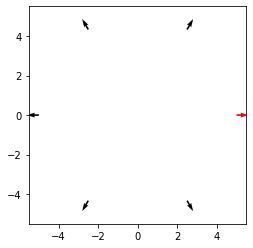

In [70]:
import matplotlib.pyplot as plt
import numpy as np
phi0=0*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
phiArr=np.arange(0, 6) * 4 * np.pi / 3
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    if rotations%2==1:
        mu = np.tan(rotations*rotationAngle/2)
        M_uc = np.asarray([[1 - mu ** 2, 2 * mu], [2 * mu, mu ** 2 - 1]]) * 1 / (1 + mu ** 2)  # reflection matrix
        mSym=M_uc@m
    else:
        M_Angle=rotationAngle*rotations
        MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
        mSym=MRot@m
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()



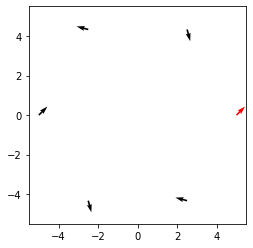

In [84]:
import matplotlib.pyplot as plt
import numpy as np
phi0=.5*np.pi/2
r=5.0
theta0=0*np.pi/2
m=np.asarray([np.cos(phi0),np.sin(phi0)])
x,y=r*np.cos(theta0),r*np.sin(theta0)
def B_Symmetry(r,rotations,rotationAngle=np.pi/3):
    xSym,ySym=r*np.cos(rotationAngle*rotations),r*np.sin(rotationAngle*rotations)
    M_Angle=rotationAngle*rotations
    MRot = np.array([[np.cos(M_Angle), -np.sin(M_Angle)], [np.sin(M_Angle), np.cos(M_Angle)]])
    mSym=MRot@m
    mSym*=(-1)**rotations
    # if rotations%2==0:
    #     mSym=-mSym
    # mSym=np.asarray([np.cos(phi0+phiArr[rotations]),np.sin(phi0+phiArr[rotations])])
    plt.quiver(xSym,ySym,*mSym)
B_Symmetry(r,1)
B_Symmetry(r,2)
B_Symmetry(r,3)
B_Symmetry(r,4)
B_Symmetry(r,5)

plt.quiver(x,y,*m,color='r')
plt.gca().set_aspect('equal')
# plt.tight_layout()
plt.xlim([-1.1*r,1.1*r])
plt.ylim([-1.1*r,1.1*r])
plt.show()

